In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Attribute Information
Age: age of the patient [years]
Sex: sex of the patient [M: Male, F: Female]
ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
RestingBP: resting blood pressure [mm Hg]
Cholesterol: serum cholesterol [mm/dl]
FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
HeartDisease: output class [1: heart disease, 0: Normal]

In [12]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [13]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [14]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [15]:
df.Sex.unique(), df.ChestPainType.unique(), df.RestingECG.unique(), df.ExerciseAngina.unique(), df.ST_Slope.unique()

(array(['M', 'F'], dtype=object),
 array(['ATA', 'NAP', 'ASY', 'TA'], dtype=object),
 array(['Normal', 'ST', 'LVH'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Up', 'Flat', 'Down'], dtype=object))

In [96]:
categorical = df.select_dtypes(include = 'object').columns.to_list()
categorical.append('FastingBS')

In [97]:
numerical = []
for col in df.columns.to_list():
    if col not in categorical:
        numerical.append(col)
numerical.remove('HeartDisease')
numerical

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [29]:
X = df.drop('HeartDisease', axis = 1).copy()
y = df['HeartDisease'].copy()

In [71]:
X_encoded = pd.get_dummies(X, columns = X.select_dtypes(include='object').columns, dtype='int')

In [113]:
columns, correlations = [], []

for col in numerical:
    columns.append(col)
    correlations.append(abs(stats.pointbiserialr(X_encoded[col], df['HeartDisease'])[0]))

num_corr = pd.DataFrame({'column': columns, 'correlation': correlations})

num_corr.style.background_gradient()

,column,correlation
0,Age,0.282039
1,RestingBP,0.107589
2,Cholesterol,0.232741
3,MaxHR,0.400421
4,Oldpeak,0.403951


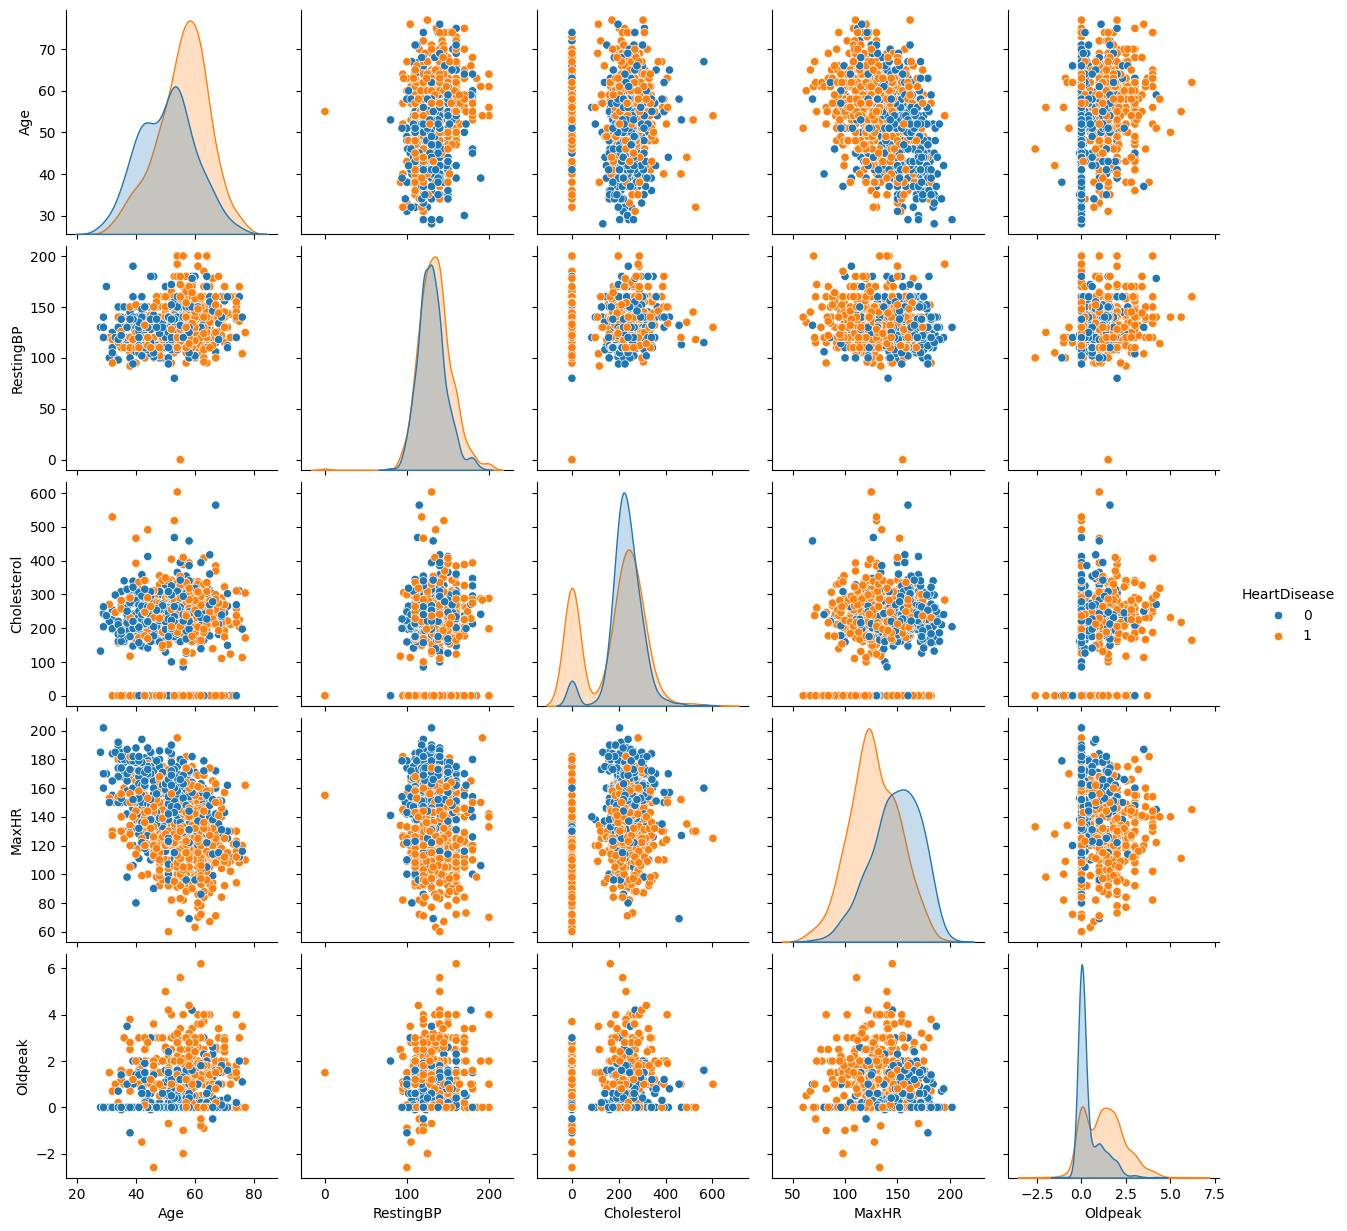

In [119]:
sns.pairplot(df[numerical+['HeartDisease']], hue = 'HeartDisease')

In [134]:
columns, correlations = [], []

for col in categorical:
    correlations.append(abs(stats.spearmanr(df[col], df['HeartDisease'])[0]))
    columns.append(col)

cat_corr = pd.DataFrame({'column': columns, 'correlation': correlations})

cat_corr.style.background_gradient()

,column,correlation
0,Sex,0.305445
1,ChestPainType,0.442516
2,RestingECG,0.056894
3,ExerciseAngina,0.494282
4,ST_Slope,0.591913
5,FastingBS,0.267291


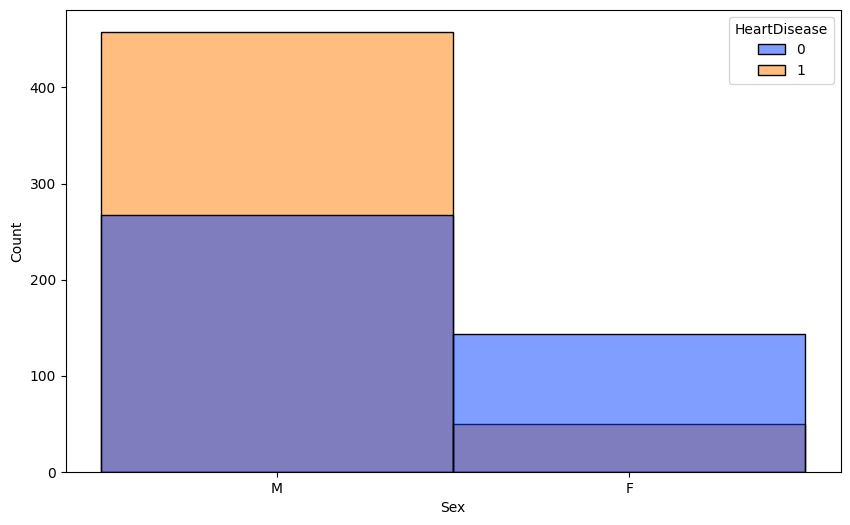

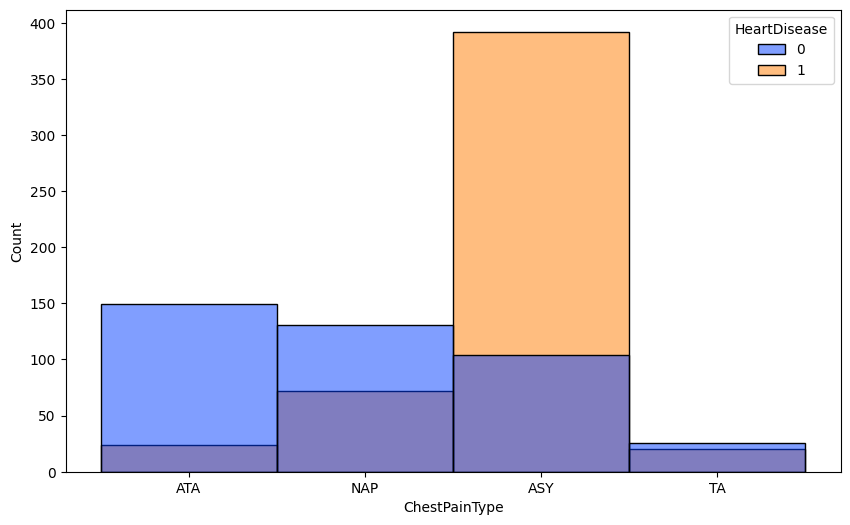

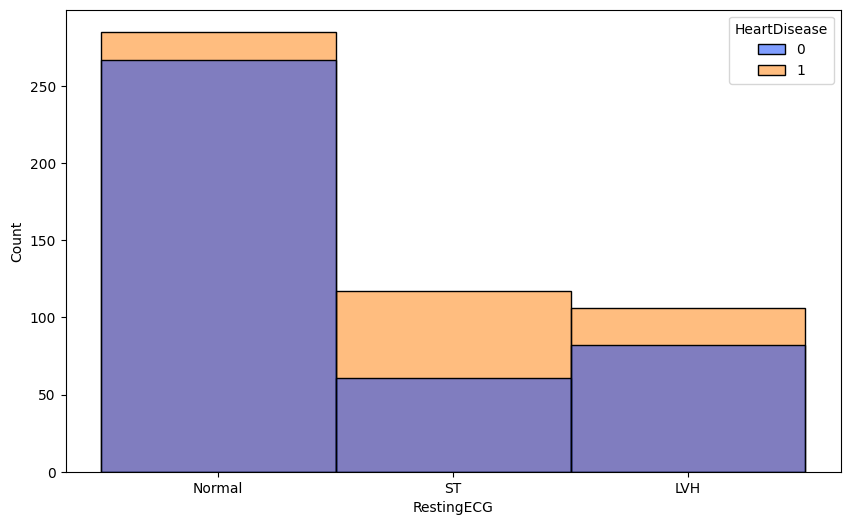

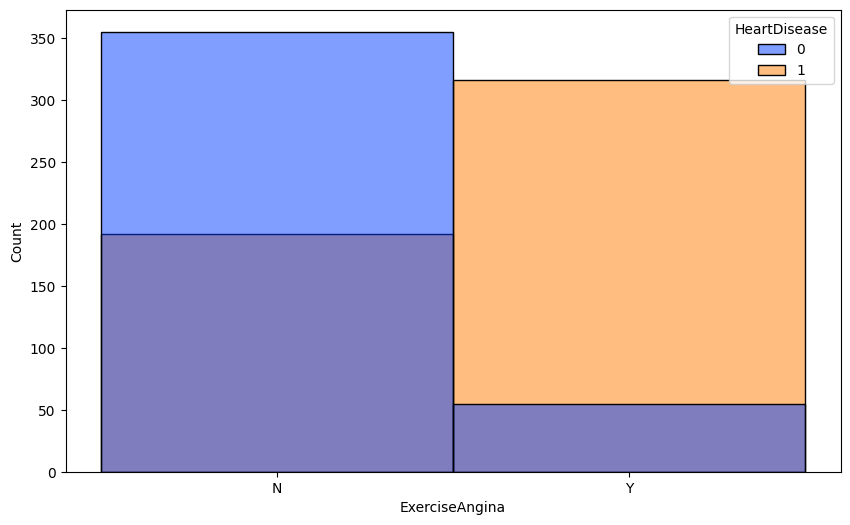

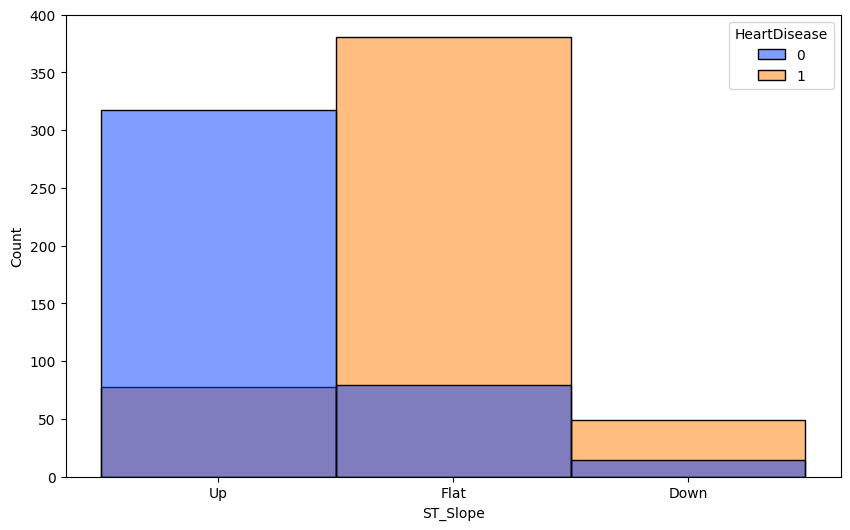

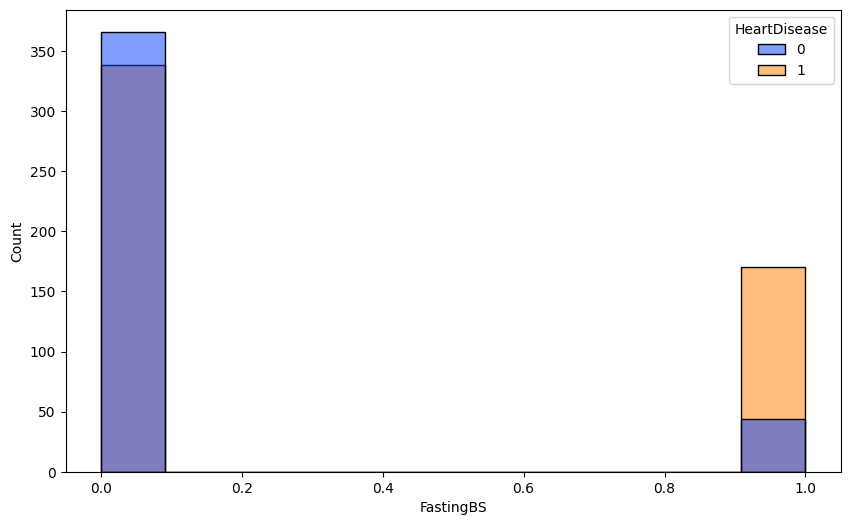

In [155]:
for c in categorical:
    plt.figure(figsize=(10,6))
    sns.histplot(data=df, x = df[c], hue=df['HeartDisease'], palette='bright', alpha = 0.5)

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.3, random_state=42)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.fit_transform(X_test)
X_train_scaled = pd.DataFrame(train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(test_scaled, columns = X_test.columns)

Логистическая регрессия

In [160]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

classification_report: 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       276
           1       0.90      0.84      0.87       367

    accuracy                           0.86       643
   macro avg       0.85      0.86      0.85       643
weighted avg       0.86      0.86      0.86       643



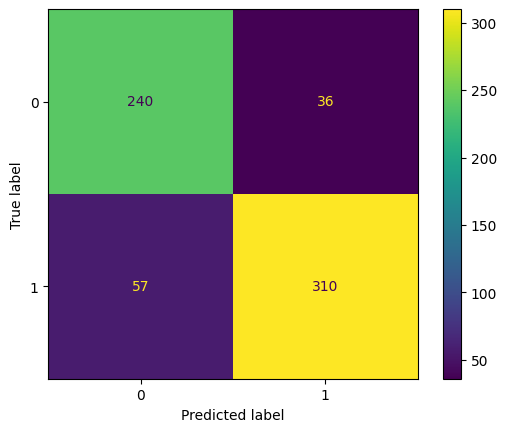

In [161]:
print('classification_report: \n', classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log, labels=log.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=log.classes_)
disp.plot()
plt.show()


RandomForestClassifier

In [167]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini'],
    'max_depth': [3,5,10],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 2, 5],

}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [3, 5, 10],
                         'max_features': ['sqrt', 'log2', 2, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7, 10],
                         'n_estimators': [50, 100, 150]},
             verbose=2)

In [168]:
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [170]:
rf = RandomForestClassifier(n_estimators=50, criterion = 'gini', max_depth = 5, min_samples_leaf= 2, min_samples_split= 5, max_features= 'sqrt', random_state = 42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=50, random_state=42)

classification_report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       276
           1       0.90      0.87      0.89       367

    accuracy                           0.87       643
   macro avg       0.87      0.87      0.87       643
weighted avg       0.87      0.87      0.87       643



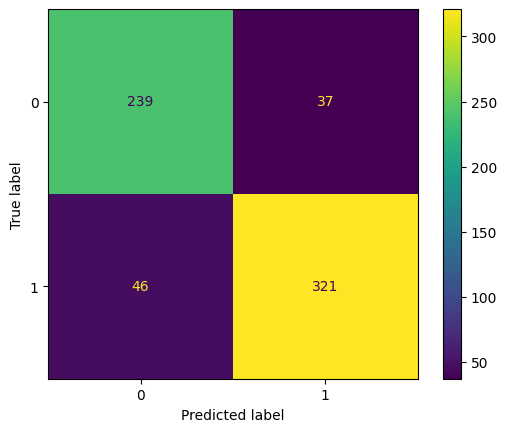

In [187]:
y_pred_rf = rf.predict(X_test_scaled)
print('classification_report: \n', classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf, labels=rf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=rf.classes_)
disp.plot()
plt.show()

XGBOOST

In [183]:
param_grid = {
    'max_depth': [3, 4, 5],
    'eta': [0.15, 0.1, 0.01],
    'gamma': [0, 1.0, 1.5],
    'reg_lambda': [0.1, 10, 15],
    'alpha': [0, 0.5, 1]
}

xgb = XGBClassifier()
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train_scaled, y_train)
xgb_grid.best_params_


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


{'alpha': 0, 'eta': 0.1, 'gamma': 1.0, 'max_depth': 4, 'reg_lambda': 10}

classification_report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       276
           1       0.88      0.90      0.89       367

    accuracy                           0.87       643
   macro avg       0.87      0.87      0.87       643
weighted avg       0.87      0.87      0.87       643



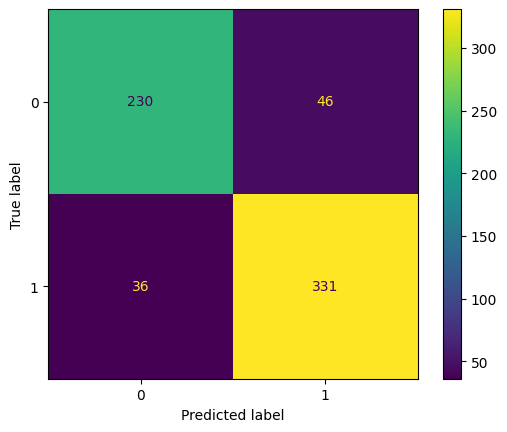

In [186]:
xgb = XGBClassifier(max_depth = 4, eta = 0.1, alpha = 0, gamma = 1.0, reg_lambda = 10)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
print('classification_report: \n', classification_report(y_test, y_pred_xgb))
cm = confusion_matrix(y_test, y_pred_xgb, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb.classes_)
disp.plot()
plt.show()

SVM

In [190]:
clf_svm = SVC(random_state = 42)

param_grid = [
    {'C': [0.5, 1, 10, 100],
     'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf', 'poly']}
]

optimal_params = GridSearchCV(SVC(),
                              param_grid=param_grid,
                              cv = 5,
                              scoring='accuracy', verbose=2)
optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.5, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ....................C=0.5, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.5, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.5, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.5, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.5, gamma=scale, kernel=poly; total time=   0.0s
[CV] END .........................C=0.5, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.5, gamma=

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

classification_report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       276
           1       0.90      0.87      0.89       367

    accuracy                           0.87       643
   macro avg       0.87      0.87      0.87       643
weighted avg       0.87      0.87      0.87       643



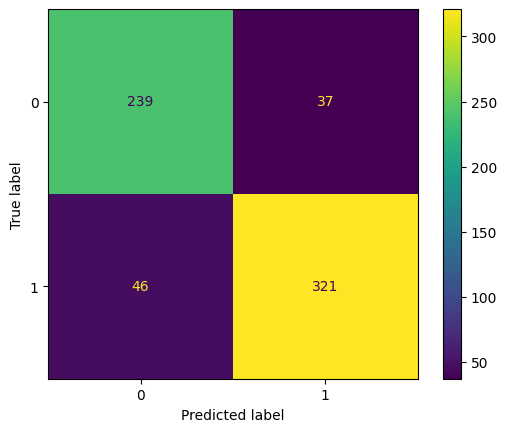

In [191]:
clf_svm = SVC(random_state = 42, C = 10, gamma = 0.001, kernel='rbf')
clf_svm.fit(X_train_scaled, y_train)
y_pred_svm = rf.predict(X_test_scaled)
print('classification_report: \n', classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test,y_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_svm.classes_)
disp.plot()
plt.show()

KNeighborsClassifier

In [195]:
grid_params = { 'n_neighbors' : [5,15, 20,25],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, grid_params, verbose = 2, cv=5, n_jobs = -1)

grid_knn.fit(X_train_scaled, y_train)
grid_knn.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}

classification_report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.85       276
           1       0.90      0.85      0.87       367

    accuracy                           0.86       643
   macro avg       0.86      0.86      0.86       643
weighted avg       0.86      0.86      0.86       643



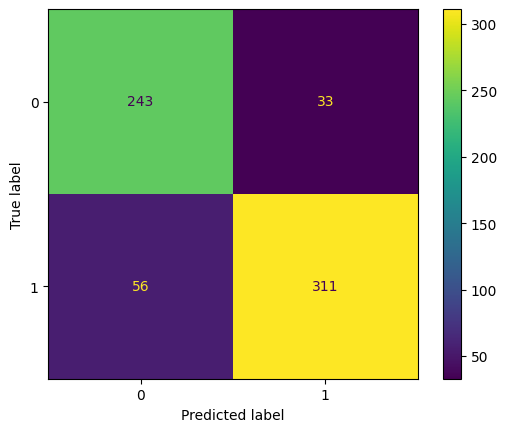

In [196]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='uniform')
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
print('classification_report: \n', classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test,y_pred_knn, labels=knn.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
disp.plot()
plt.show()

Стэкинг

In [212]:
base_classifiers = [
    ('xgb', XGBClassifier(max_depth = 4, eta = 0.1, alpha = 0, gamma = 1.0, reg_lambda = 10)),
    ('rf', RandomForestClassifier(n_estimators=50, criterion = 'gini', max_depth = 5, min_samples_leaf= 2, min_samples_split= 5, max_features= 'sqrt', random_state = 42)),
    ('knn', KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='uniform'),
    ('svc', SVC(random_state = 42, C = 10, gamma = 0.001, kernel='rbf')))
]
meta_classifier = LogisticRegression()

# Создание модели Stacking
stack_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier, cv=5)

# Обучение модели
stack_model.fit(X_train_scaled, y_train)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(alpha=0, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False, eta=0.1,
                                              eval_metric=None,
                                              feature_types=None, gamma=1.0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constr...
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None, ...)),
                               ('rf',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=20),
                                ('svc',
                                 SVC(C=10, gamma=0.001, random_state=42)))],
                   final_estimator=LogisticRegression())

classification_report: 
               precision    recall  f1-score   support

           0       0.84      0.87      0.85       276
           1       0.90      0.87      0.89       367

    accuracy                           0.87       643
   macro avg       0.87      0.87      0.87       643
weighted avg       0.87      0.87      0.87       643



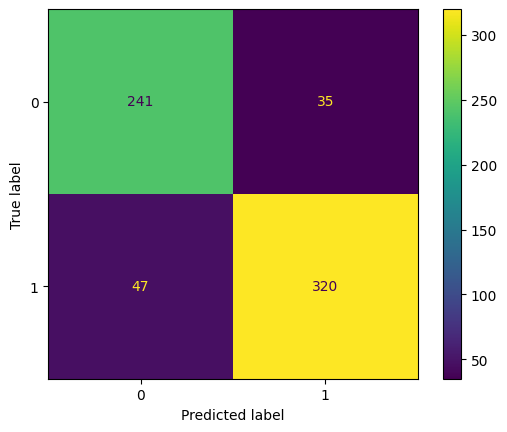

In [213]:
y_pred_stack = stack_model.predict(X_test_scaled)
print('classification_report: \n', classification_report(y_test, y_pred_stack))
cm = confusion_matrix(y_test,y_pred_stack, labels=stack_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=stack_model.classes_)
disp.plot()
plt.show()

Визуализация результата

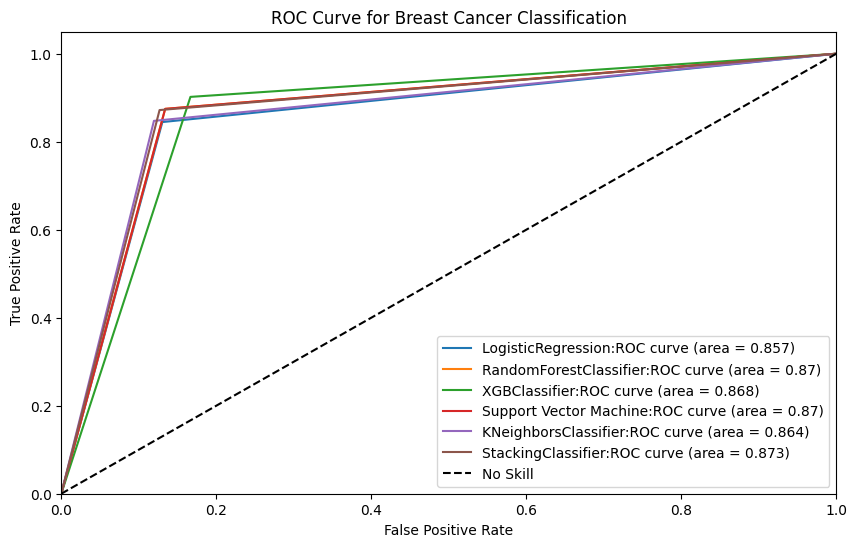

In [214]:
y_pred = [y_pred_log, y_pred_rf, y_pred_xgb, y_pred_svm, y_pred_knn, y_pred_stack]
labels = ['LogisticRegression', 'RandomForestClassifier','XGBClassifier', 'Support Vector Machine', 'KNeighborsClassifier', 'StackingClassifier']
plt.figure(figsize = (10,6))
for y, label in zip(y_pred, labels):
    fpr, tpr, thresholds = roc_curve(y_test, y) 
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label}:ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

Аномалии

Проведем детекцию аномалий на основании содержания Холестерола, так как на точечной диаграмме видны явные выбросы

In [265]:
X_an = X['Cholesterol']

Метод квартилей

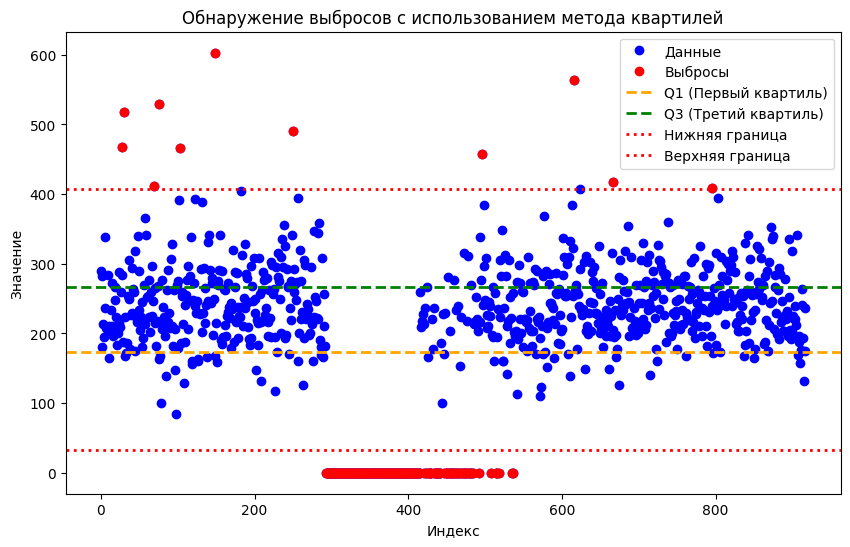

In [276]:
X_an_array = X_an.to_numpy()

Q1 = np.percentile(X_an_array, 25)
Q3 = np.percentile(X_an_array, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = np.where((X_an < lower_bound) | (X_an > upper_bound))

plt.figure(figsize=(10, 6))
plt.plot(X_an_array, 'bo', label='Данные')
plt.plot(outliers[0],X_an_array[outliers],'ro', label='Выбросы')
plt.axhline(Q1, color='orange', linestyle='dashed', linewidth=2, label='Q1 (Первый квартиль)')
plt.axhline(Q3, color='green', linestyle='dashed', linewidth=2, label='Q3 (Третий квартиль)')
plt.axhline(lower_bound, color='red', linestyle='dotted', linewidth=2, label='Нижняя граница')
plt.axhline(upper_bound, color='red', linestyle='dotted', linewidth=2, label='Верхняя граница')

plt.title('Обнаружение выбросов с использованием метода квартилей')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()
